In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn import datasets, decomposition

import matplotlib
import matplotlib.pyplot as plt

import joblib

import os

SEED = 11



np.random.seed(SEED)

In [2]:
DATASET_DIR = '../Dataset'

N_MODELS = 5
N_INSTANCES = 1000
N_FEATURES = 20
N_SELECTION = 10

In [3]:
def get_data(nmodels, ninstances, ndims, nfeatures, nbins=5, randomize=True):
    
    X = []
    masks = []
    means = []
    stddevs = []
    
    ft_stddev = 2 / nbins
    ft_means = [i for i in np.arange(-1, 1, ft_stddev)]
    
    # Generate data and masks for each model
    for i in range(nmodels):    
        
        # Select the number of features for each model
        nfeat =  np.random.randint(nfeatures) if randomize else nfeatures
        
        # Generate mask for selected features at random
        # Sort indices for features
        sort_fn = np.arange(ndims)
        np.random.shuffle(sort_fn)        
        
        mask = np.zeros(ndims)
        mask[:nfeat] = 1
        mask = mask[sort_fn]
        
        mean = np.zeros(ndims)
        mean[:nfeat] = np.random.choice(ft_means, size=(nfeat,))
        mean = mean[sort_fn]
        
        stddev = np.ones(ndims)
        stddev[:nfeat] = ft_stddev
        stddev = stddev[sort_fn]    
        
        # Data generation        
        x = np.random.normal(size=(ninstances, ndims))
        x = x * stddev + mean
        
        masks.append(mask)
        means.append(mean)
        stddevs.append(stddev)
        X.append(x)
    
    return X, masks, means, stddevs

In [4]:
def get_linear_model(ndims, fn=np.sign):
    w = np.random.normal(size=(ndims,))
    
    def linear_model(x):
        return fn(np.matmul(x, w))
    
    return linear_model

In [5]:
models = []

for i in range(N_MODELS):
    models.append(get_linear_model(N_FEATURES))

In [6]:
X, masks, means, varis = get_data(N_MODELS, N_INSTANCES, N_FEATURES, N_SELECTION, randomize=False)

In [7]:
labels = [model(x) for model, x in zip(models, X)]

In [8]:
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(np.vstack(X))

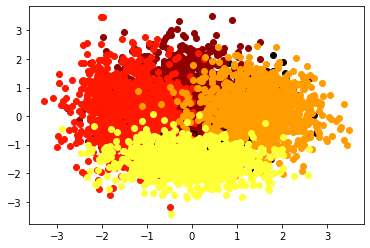

In [9]:
for model in range(N_MODELS):
    plt.scatter(
        X_pca[model * N_INSTANCES:(model + 1) * N_INSTANCES, 0], 
        X_pca[model * N_INSTANCES:(model + 1) * N_INSTANCES, 1], 
        color=matplotlib.cm.hot(model / N_MODELS)
    )

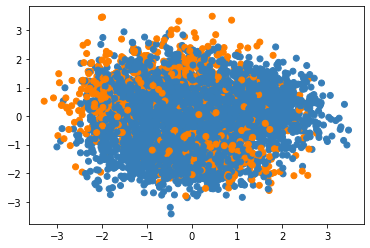

In [10]:
colors=np.array(['#377eb8', '#ff7f00'])

plt.scatter(X_pca[:, 0], X_pca[:, 1], color=colors[(np.array(labels).flatten() > 0).astype(int)])

In [11]:
COLUMNS = ['x{}'.format(i) for i in range(N_FEATURES)] + ['y']

NUMERICAL_COLS = ['x{}'.format(i) for i in range(N_FEATURES)] + ['model']

CATEGORICAL_COLS = []

TARGET_COLUMN = 'y'

In [12]:
np.hstack([np.ones(N_INSTANCES) * i for i in range(N_MODELS)])

array([0., 0., 0., ..., 4., 4., 4.])

In [13]:
df = pd.DataFrame(
    np.hstack((
        np.vstack(X), 
        np.array(labels).flatten()[:,np.newaxis]
    )), columns=COLUMNS)

df['model'] = np.hstack([np.ones(N_INSTANCES) * i for i in range(N_MODELS)])

df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x12,x13,x14,x15,x16,x17,x18,x19,y,model
0,0.516552,-0.635761,0.472852,-0.139711,-1.212857,0.687547,0.185663,1.832777,-1.128894,-0.593201,...,1.263682,0.378641,0.014174,0.153841,-0.293536,-0.994028,-0.264342,1.542209,1.0,0.0
1,0.856152,-0.617921,0.009004,-0.261626,-1.220432,0.977214,0.341153,0.138273,-1.297423,-0.885985,...,0.401308,0.505022,0.575513,-0.675020,-0.812343,-0.869862,-1.155264,0.796672,1.0,0.0
2,0.510028,-0.464514,-0.268848,-0.618387,-0.627067,0.434716,0.120083,-0.698972,0.654025,0.119792,...,0.628408,0.921575,0.049268,0.919983,-0.751369,-0.488975,-0.644394,0.699141,1.0,0.0
3,0.275407,-0.525470,-0.255922,-0.143278,-1.176288,1.190605,-0.131553,0.194429,-0.105149,-1.233585,...,1.196989,-1.115237,-0.082166,-0.047233,-1.274912,-1.697342,-0.411454,-0.045275,1.0,0.0
4,-0.391173,0.013689,0.134323,-0.055853,0.039220,1.281489,-1.589520,-0.377247,1.162506,-1.151543,...,0.055226,-1.134185,0.270737,1.268926,0.011209,0.011888,-1.970572,-0.056633,1.0,0.0


In [14]:
df[TARGET_COLUMN] = df[TARGET_COLUMN].replace({-1: 0})

## Split train / test

In [15]:
# 80% Train (Train and dev), 20% Test
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(TARGET_COLUMN, axis=1), 
    df[TARGET_COLUMN], 
    test_size=0.2, 
    random_state=SEED
)

# 60% train, 20% dev
# 0.25 x 0.8 = 0.2
X_train, X_dev, y_train, y_dev = train_test_split(
    X_train, 
    y_train, 
    test_size=0.25, 
    random_state=SEED
)    

In [16]:
train_df = X_train
train_df[TARGET_COLUMN] = y_train

dev_df = X_dev
dev_df[TARGET_COLUMN] = y_dev

test_df = X_test
test_df[TARGET_COLUMN] = y_test

## Save data

In [17]:
ds_info = {
    'columns': COLUMNS,
    'categorical_columns': CATEGORICAL_COLS,
    'numerical_columns': NUMERICAL_COLS,
    'target_column': TARGET_COLUMN
}

In [18]:
_ = joblib.dump(ds_info, os.path.join(DATASET_DIR, 'ds_info.jl'))

In [19]:
train_df.to_csv(os.path.join(DATASET_DIR, 'n_train.csv'), index=False)
dev_df.to_csv(os.path.join(DATASET_DIR, 'n_dev.csv'), index=False)
test_df.to_csv(os.path.join(DATASET_DIR, 'n_test.csv'), index=False)